<a href="https://colab.research.google.com/github/Parshantladhar/Handwritten-Digit-Generator/blob/main/cDCGAN_with_GUI(Gradio).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import PIL
import imageio
from IPython import display

In [56]:
# Constants
BUFFER_SIZE = 60000
BATCH_SIZE = 128
LEARNING_RATE_G = 2e-4
LEARNING_RATE_D = 5e-4
EPOCHS = 100
noise_dim = 100
num_classes = 10  # For digits 0-9

In [57]:
# Set mixed precision for better performance
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [58]:
def load_mnist():
    # Load and prepare the MNIST dataset
    (train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

    # Reshape and normalize images
    train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
    train_images = (train_images - 127.5) / 127.5

    # Convert labels to one-hot encoding
    train_labels = tf.one_hot(train_labels, depth=num_classes)

    # Create tf.data.Dataset
    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return train_dataset

In [59]:
# Use a simpler approach instead of custom SpectralNormalization
def make_generator_model():
    # Input for noise vector
    noise_input = layers.Input(shape=(noise_dim,))

    # Input for digit class (one-hot encoded)
    digit_input = layers.Input(shape=(num_classes,))

    # Embedding for digit conditioning (linear projection)
    digit_embedding = layers.Dense(noise_dim)(digit_input)

    # Combine noise and digit embedding (element-wise multiplication)
    combined_input = layers.Multiply()([noise_input, digit_embedding])

    # Dense layer and reshape
    x = layers.Dense(7*7*256, use_bias=False)(combined_input)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Reshape((7, 7, 256))(x)

    # Upsampling blocks
    x = layers.UpSampling2D(size=(2, 2))(x)
    x = layers.Conv2D(128, (3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.UpSampling2D(size=(2, 2))(x)
    x = layers.Conv2D(64, (3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    # Output layer with tanh activation
    output = layers.Conv2D(1, (3, 3), padding='same', use_bias=False, activation='tanh')(x)

    # Create model with two inputs
    model = tf.keras.Model(inputs=[noise_input, digit_input], outputs=output)

    return model

In [60]:
def make_discriminator_model():
    # Input for images
    image_input = layers.Input(shape=[28, 28, 1])

    # Input for digit class (one-hot encoded)
    digit_input = layers.Input(shape=(num_classes,))

    # Process digit conditioning
    digit_embedding = layers.Dense(28*28)(digit_input)
    digit_embedding = layers.Reshape((28, 28, 1))(digit_embedding)

    # Combine image and digit embedding
    x = layers.Concatenate()([image_input, digit_embedding])

    # Convolutional layers (using standard Conv2D now)
    x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                     kernel_initializer=tf.keras.initializers.Orthogonal(gain=0.8))(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same',
                     kernel_initializer=tf.keras.initializers.Orthogonal(gain=0.8))(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.3)(x)

    # Dense layers
    x = layers.Flatten()(x)
    x = layers.Dense(128, kernel_initializer=tf.keras.initializers.Orthogonal(gain=0.8))(x)
    x = layers.LeakyReLU(0.2)(x)
    output = layers.Dense(1)(x)

    # Create model with two inputs
    model = tf.keras.Model(inputs=[image_input, digit_input], outputs=output)

    return model

In [61]:
# Create generator and discriminator
generator = make_generator_model()
discriminator = make_discriminator_model()

In [62]:
# Loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [63]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output) * 0.9, real_output)  # Smoothed labels
    fake_loss = cross_entropy(tf.zeros_like(fake_output) * 0.1, fake_output)  # Smoothed labels
    total_loss = real_loss + fake_loss
    return total_loss

In [64]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [65]:
# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE_G, beta_1=0.5, beta_2=0.999)
discriminator_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE_D, beta_1=0.5, beta_2=0.999)

In [66]:
# Checkpoint setup
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator_optimizer=discriminator_optimizer,
                                generator=generator,
                                discriminator=discriminator)

In [67]:
# Create seed for visualization
num_examples_to_generate = 16
seed_noise = tf.random.normal([num_examples_to_generate, noise_dim])
seed_digits = tf.one_hot([i % 10 for i in range(num_examples_to_generate)], num_classes)

In [68]:
@tf.function
def train_step(images, labels):
    # Generate random noise and random digit labels
    batch_size = tf.shape(images)[0]
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate fake images
        generated_images = generator([noise, labels], training=True)

        # Get discriminator decisions
        real_output = discriminator([images, labels], training=True)
        fake_output = discriminator([generated_images, labels], training=True)

        # Calculate losses
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Calculate gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply gradients
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [69]:
def generate_and_save_images(model, epoch, test_input_noise, test_input_digits):
    # Ensure the prediction is in float32 for imshow
    # Use .numpy() to convert the EagerTensor to a NumPy array before using .astype()
    predictions = model([test_input_noise, test_input_digits], training=False).numpy().astype('float32')

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        # Squeeze the channel dimension to match the expected shape for imshow
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.title(f"Digit: {tf.argmax(test_input_digits[i]).numpy()}")
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.close(fig)

    return fig

In [70]:
# Training history
history = {"gen_loss": [], "disc_loss": [], "accuracy": []}

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        epoch_gen_loss = 0
        epoch_disc_loss = 0
        steps = 0

        for image_batch, label_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch, label_batch)
            epoch_gen_loss += gen_loss
            epoch_disc_loss += disc_loss
            steps += 1

        # Calculate average losses
        epoch_gen_loss /= steps
        epoch_disc_loss /= steps

        # Update history
        history["gen_loss"].append(epoch_gen_loss.numpy())
        history["disc_loss"].append(epoch_disc_loss.numpy())
        history["accuracy"].append(1 - (epoch_gen_loss.numpy() / (epoch_gen_loss.numpy() + epoch_disc_loss.numpy())))

        # Generate and save images
        display.clear_output(wait=True)
        fig = generate_and_save_images(generator, epoch + 1, seed_noise, seed_digits)

        # Save checkpoint
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Generator Loss: {epoch_gen_loss:.4f}, Discriminator Loss: {epoch_disc_loss:.4f}")
        print(f"Time: {time.time()-start:.2f} sec")

    # Save final history
    np.save("training_history.npy", history)

Epoch 100/100
Generator Loss: 0.9428, Discriminator Loss: 1.3012
Time: 10.69 sec


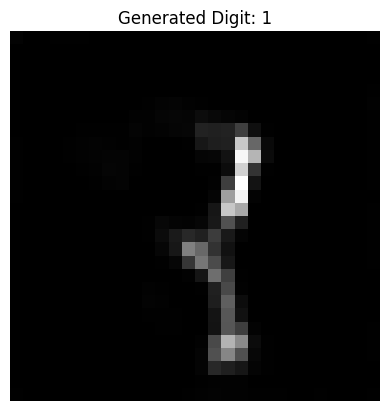

In [71]:
# Load and train
train_dataset = load_mnist()
train(train_dataset, EPOCHS)  # Train for just 1 epoch to test

In [72]:
# Save models
generator.save("generator_model.keras")
discriminator.save("discriminator_model.keras")
print("Models saved successfully in Keras format!")

Models saved successfully in Keras format!


In [73]:
# Gradio interface
import gradio as gr

# Load the model (uncomment when you have a trained model)
# generator = tf.keras.models.load_model("generator_model.keras", compile=False)

device = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"
print(f"Using device: {device}")

def generate_digit(digit=None):
    if digit is None:
        digit = np.random.randint(0, 10)
    digit = np.clip(int(digit), 0, 9)

    # Create one-hot encoding
    digit_one_hot = np.zeros((1, 10))
    digit_one_hot[0, digit] = 1

    # Generate random noise
    random_noise = np.random.randn(1, noise_dim)

    with tf.device(device):
        # Generate image using both noise and digit class
        generated_image = generator.predict([random_noise, digit_one_hot])

    # Process image for display
    generated_image = generated_image.reshape(28, 28)
    generated_image = generated_image * 127.5 + 127.5  # Denormalize

    fig, ax = plt.subplots()
    ax.imshow(generated_image, cmap="gray")
    ax.set_title(f"Generated Digit: {digit}")
    ax.axis("off")

    return fig

def analyze_performance():
    try:
        history = np.load("training_history.npy", allow_pickle=True).item()

        if not history:
            return "No valid performance data found!"

        gen_loss = history.get("gen_loss", [])
        disc_loss = history.get("disc_loss", [])
        accuracy = history.get("accuracy", [])
        epochs = range(1, len(gen_loss) + 1)

        fig, ax = plt.subplots(1, 2, figsize=(12, 5))

        # Plot losses
        ax[0].plot(epochs, gen_loss, "r-", label="Generator Loss")
        ax[0].plot(epochs, disc_loss, "b-", label="Discriminator Loss")
        ax[0].set_title("Model Losses Over Epochs")
        ax[0].set_xlabel("Epochs")
        ax[0].set_ylabel("Loss")
        ax[0].legend()

        # Plot accuracy
        ax[1].plot(epochs, accuracy, "g-", label="Generator Accuracy")
        ax[1].set_title("Model Accuracy Over Epochs")
        ax[1].set_xlabel("Epochs")
        ax[1].set_ylabel("Accuracy")
        ax[1].legend()

        return fig

    except Exception as e:
        return f"Error: {e}"

# Create Gradio interface
with gr.Blocks() as demo:
    gr.Markdown("# ✍️ Handwritten Digit Generator")
    gr.Markdown("Generate a **random** or **specific** handwritten digit using Conditional GAN! 🚀")

    with gr.Row():
        btn_random = gr.Button("🎲 Generate Random Digit")
        num_input = gr.Number(label="Enter Digit (0-9)", value=0, minimum=0, maximum=9, step=1)
        btn_specific = gr.Button("🎯 Generate Specific Digit")

    output_image = gr.Plot()

    btn_random.click(generate_digit, inputs=None, outputs=output_image)
    btn_specific.click(generate_digit, inputs=num_input, outputs=output_image)

    gr.Markdown("## 📊 Model Performance Analysis")
    btn_analysis = gr.Button("📈 Show Performance")
    output_analysis = gr.Plot()

    btn_analysis.click(analyze_performance, inputs=None, outputs=output_analysis)

# Launch the interface
if __name__ == "__main__":
    demo.launch(share=True)

Using device: /GPU:0
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://43be03abfa8cf84dee.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
